# Infill stylised pathway
Here we generate a portfolio of stylised CO2 pathways and infill them with other gases. Pathways are generated based on the functional form suggested in "What would it take to achieve the Paris temperature targets?" (Sanderson et al, 2016)

In [1]:
import os.path

import pandas as pd
import pyam
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import numpy as np
from silicone.utils import (
    _get_unit_of_variable,
    find_matching_scenarios,
    download_or_load_sr15,
    convert_units_to_MtCO2_equiv
)
import silicone.multiple_infillers as mi
import silicone.database_crunchers as cr

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


# Download data
We use the SR1.5 database to perform our infilling and use the CMIP5 database to provide the RCP8.5 and RCP2.6 pathways required by the stylised path equations. 

In [2]:
sr15_file = "./../Input/complete_sr15.csv"
download_or_load_sr15(sr15_file)    

# We are only interested in the worldwide record
df = pyam.IamDataFrame(sr15_file).filter(region="World") 
df.head()

pyam.utils - INFO: Reading `./../Input/complete_sr15.csv`
pyam.utils - INFO: Reading `./../Input/complete_sr15.csv`


,model,scenario,region,variable,unit,year,meta,subannual,value
0,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2005,0,0.0,8.3367
1,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2010,0,0.0,7.6408
2,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2015,0,0.0,7.2724
3,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2020,0,0.0,7.0752
4,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2025,0,0.0,5.8486


In [3]:
rcmip_file = "./../Input/DownloadedRCMIP_RCPs.csv"
rcmip_df = pyam.IamDataFrame(rcmip_file)

pyam.utils - INFO: Reading `./../Input/DownloadedRCMIP_RCPs.csv`


Our basic input has separate functional forms for CO2 from land use and total CO2. We will base our pathway on the AIM/CGE 2.0 model. It requires three free parameters, $\tau$ (a decay constant), $t_m$ (a time to start the transition) and $E_\infty$, the long-run total CO2 emissions. There are two additional parameters defined by continuity conditions, $A$ and $t_e$. Note that we will slightly redefine A from the paper (and correct what appears be a sign error before $E_\infty$) so that $E_{CO_2} = A(t-t_e)E^{-(t-t_e)/\tau}+E_\infty$. 

We will arbitrarily select $t_m = 2025, \tau = 10$ or 30 and $E_\infty = \pm 3400$ (The negative case is around the 2150 limit of the RCP2.6 scenario)

In [4]:
rcmip_df.filter(variable="Emissions|CO2", year=2150).data.head()

,model,scenario,region,variable,unit,year,value
135,AIM,rcp60,World,Emissions|CO2,Mt CO2/yr,2150,12856.066670
543,IMAGE,rcp26,World,Emissions|CO2,Mt CO2/yr,2150,-3412.933333
951,MESSAGE,rcp85,World,Emissions|CO2,Mt CO2/yr,2150,105380.000000
1359,MiniCAM,rcp45,World,Emissions|CO2,Mt CO2/yr,2150,5671.600000


In [5]:
taus = [10, 30]
t_m = 2025
E_infs = [3400, -3400]
t_max = 2100

We can construct the basis of the paths to infill

In [6]:
AFOLU = "Emissions|CO2|MAGICC AFOLU"
construct = rcmip_df.filter(scenario="rcp85", year=range(t_m))
ELU85 = rcmip_df.filter(
    variable=AFOLU, scenario="rcp85", year=range(t_m, t_max + 1)
)
ELU26 = rcmip_df.filter(
    variable=AFOLU, scenario="rcp26", year=range(t_m, t_max + 1)
)
ELU85.data.reset_index(inplace=True, drop=True)
ELU26.data.reset_index(inplace=True, drop=True)
ELU26.head()

,model,scenario,region,variable,unit,year,value
0,IMAGE,rcp26,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2025,3229.783333
1,IMAGE,rcp26,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2026,3162.353333
2,IMAGE,rcp26,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2027,3094.923333
3,IMAGE,rcp26,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2028,3027.493333
4,IMAGE,rcp26,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2029,2960.063333


In [7]:
constructed_df = None
def scenario_fn(tau, E_inf):
    return "tau_" + str(tau) + "_E-inf_" + str(E_inf)
def AFOLU_fn(t, t_m, tau, E85, E26):
    return E85 * np.exp(-(t - t_m) / tau)  + E26 * (1 - np.exp(-(t - t_m) / tau))
for tau in taus:
    for E_inf in E_infs:
        output = construct.copy()
        to_add = ELU85.copy()
        to_add["value"] = AFOLU_fn(ELU85["year"], t_m, tau, ELU85["value"], ELU26["value"])
        output.append(to_add, inplace=True)
        output["scenario"] = scenario_fn(tau, E_inf)
        if constructed_df:
            constructed_df.append(output, inplace=True)
        else:
            constructed_df = pyam.IamDataFrame(output.data)

In [8]:
constructed_df=pyam.IamDataFrame(constructed_df.data)
constructed_df.filter(variable="*CO2|MAGICC A*").data

,model,scenario,region,variable,unit,year,value
10,MESSAGE,tau_10_E-inf_-3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2015,3575.366667
11,MESSAGE,tau_10_E-inf_-3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2016,3525.060000
12,MESSAGE,tau_10_E-inf_-3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2017,3474.753333
13,MESSAGE,tau_10_E-inf_-3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2018,3424.446667
14,MESSAGE,tau_10_E-inf_-3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2019,3374.140000
...,...,...,...,...,...,...,...
409,MESSAGE,tau_30_E-inf_3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2096,1862.584019
410,MESSAGE,tau_30_E-inf_3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2097,1833.098929
411,MESSAGE,tau_30_E-inf_3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2098,1803.513626
412,MESSAGE,tau_30_E-inf_3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2099,1773.830472


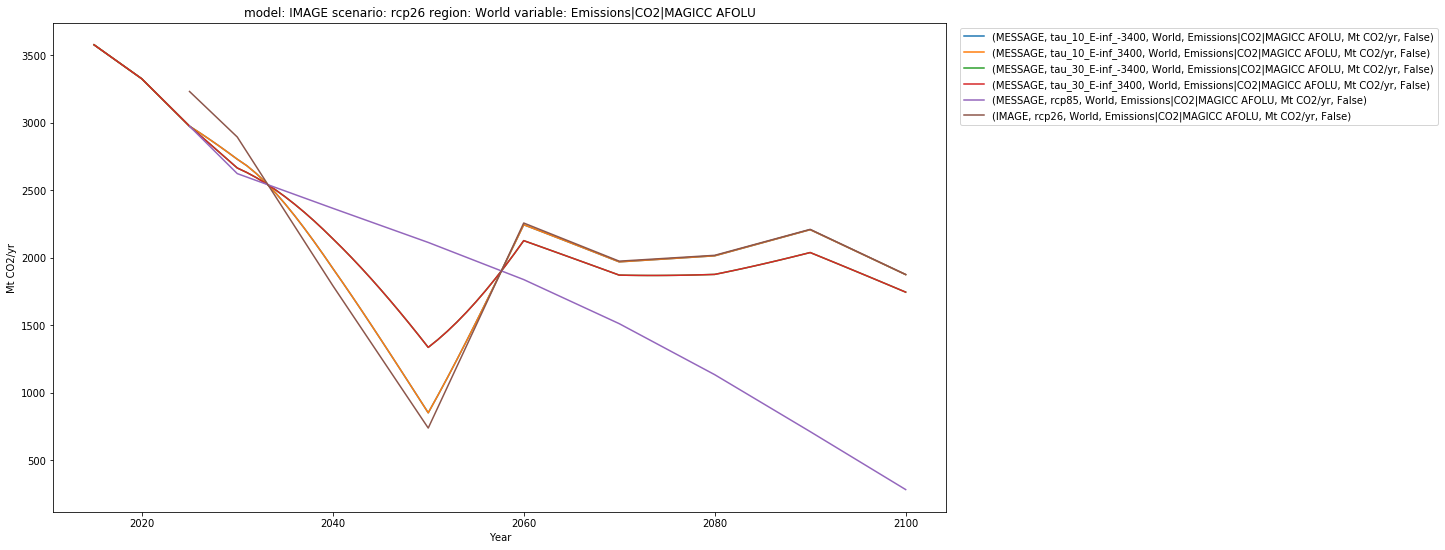

In [9]:
fig = plt.figure(figsize=(16, 9))
ax = plt.subplot(111)
constructed_df.filter(variable=AFOLU).line_plot(ax=ax)
ELU85.line_plot(ax=ax)
ELU26.line_plot(ax=ax)
plt.legend(bbox_to_anchor=(1.01,1), loc="upper left")

In [10]:
ELU85.data

,model,scenario,region,variable,unit,year,value
0,MESSAGE,rcp85,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2025,2972.750000
1,MESSAGE,rcp85,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2026,2902.533333
2,MESSAGE,rcp85,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2027,2832.316667
3,MESSAGE,rcp85,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2028,2762.100000
4,MESSAGE,rcp85,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2029,2691.883333
...,...,...,...,...,...,...,...
71,MESSAGE,rcp85,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2096,453.933333
72,MESSAGE,rcp85,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2097,411.033333
73,MESSAGE,rcp85,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2098,368.133333
74,MESSAGE,rcp85,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2099,325.233333


In [11]:
def ETOT_fn(t, t_m, tau, t_e, A, E_inf):
    return A * (t-t_e) * np.exp(-(t-t_m)/tau) + E_inf
t_step = 1
ETOT_86 = rcmip_df.filter(
    variable="Emissions|CO2", scenario="rcp85", year=range(t_m - t_step, t_m + t_step + 1)
).data.set_index("year")
for tau in taus:
    for E_inf in E_infs:
        output = ELU85.copy()
        # A = (\tau dE/dt + E - E_inf)/(1 + \tau) evaluated at t_m
        A = (tau * (ETOT_86["value"].loc[t_m + t_step] - ETOT_86["value"].loc[t_m - t_step]) / (2 * t_step) \
            + (ETOT_86["value"].loc[t_m] - E_inf)) / (1 + tau)
        t_e = t_m - (ETOT_86["value"].loc[t_m] - E_inf) / A
        output["value"] = ETOT_fn(np.arange(t_m, t_max + 1), t_m, tau, t_e, A, E_inf)
        output["scenario"] = scenario_fn(tau, E_inf)
        output["variable"] = "Emissions|CO2"
        constructed_df.append(output, inplace=True)

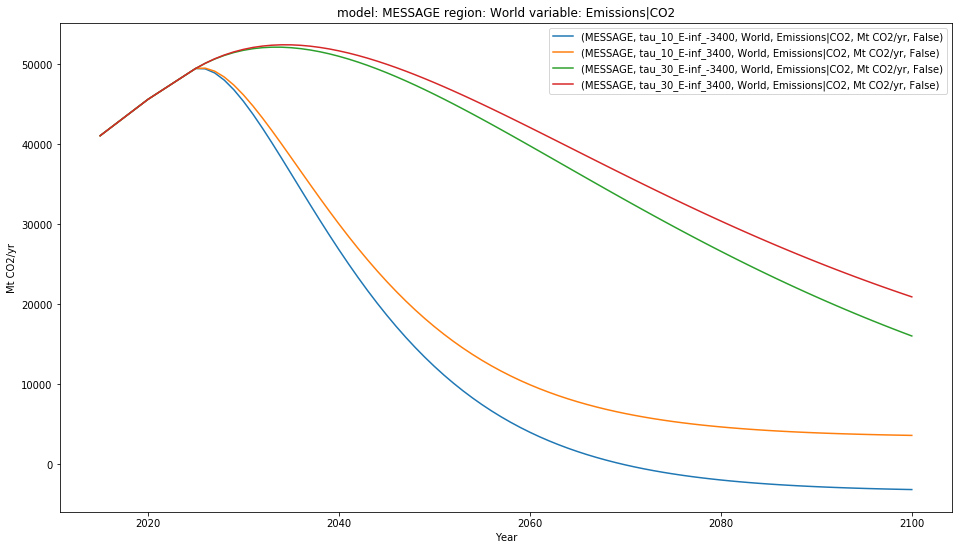

In [12]:
fig = plt.figure(figsize=(16, 9))
ax = plt.subplot(111)
constructed_df.filter(variable="Emissions|CO2").line_plot(ax=ax)

In [13]:
industry_str = "Emissions|CO2|MAGICC Fossil and Industrial"
ind_CO2 = mi.infill_composite_values(constructed_df, {industry_str: {
    "Emissions|CO2": 1, AFOLU: -1
}})
ind_CO2.filter(variable="Emissions|CO2*", year=2020).head()

,model,scenario,region,variable,unit,year,value
5,MESSAGE,tau_10_E-inf_-3400,World,Emissions|CO2|MAGICC Fossil and Industrial,Mt CO2/yr,2020,42304.166667
91,MESSAGE,tau_10_E-inf_3400,World,Emissions|CO2|MAGICC Fossil and Industrial,Mt CO2/yr,2020,42304.166667
177,MESSAGE,tau_30_E-inf_-3400,World,Emissions|CO2|MAGICC Fossil and Industrial,Mt CO2/yr,2020,42304.166667
263,MESSAGE,tau_30_E-inf_3400,World,Emissions|CO2|MAGICC Fossil and Industrial,Mt CO2/yr,2020,42304.166667


In [14]:
ind_CO2.filter(variable="Emissions|CO2|*", year=2020).head(10)

,model,scenario,region,variable,unit,year,value
5,MESSAGE,tau_10_E-inf_-3400,World,Emissions|CO2|MAGICC Fossil and Industrial,Mt CO2/yr,2020,42304.166667
91,MESSAGE,tau_10_E-inf_3400,World,Emissions|CO2|MAGICC Fossil and Industrial,Mt CO2/yr,2020,42304.166667
177,MESSAGE,tau_30_E-inf_-3400,World,Emissions|CO2|MAGICC Fossil and Industrial,Mt CO2/yr,2020,42304.166667
263,MESSAGE,tau_30_E-inf_3400,World,Emissions|CO2|MAGICC Fossil and Industrial,Mt CO2/yr,2020,42304.166667


In [15]:
constructed_df.append(ind_CO2.filter(year=range(t_m), keep=False), inplace=True)

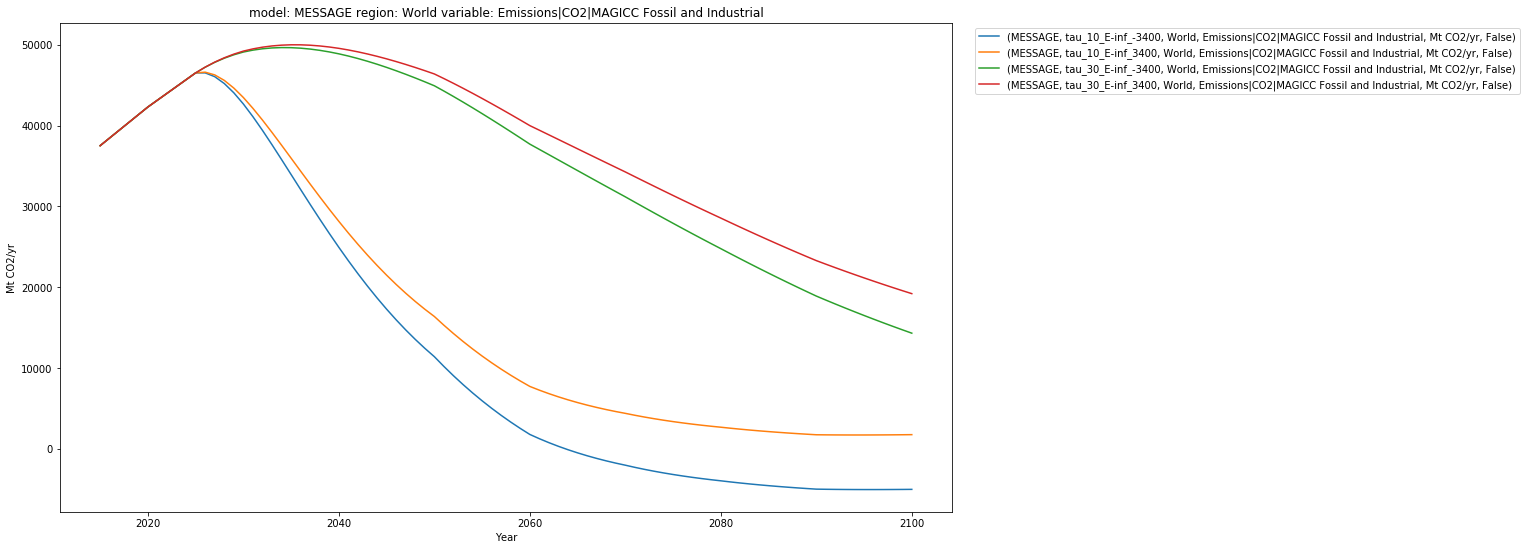

In [16]:
fig = plt.figure(figsize=(16, 9))
ax = plt.subplot(111)
constructed_df.filter(variable=industry_str).line_plot(ax=ax)
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")

## Compare with Silicone results
We can now compare the pathways implied by this method with the pathways infilled by our crunchers. We begin with the rolling quantile cruncher

In [22]:
cruncher_rcmip = cr.DatabaseCruncherQuantileRollingWindows(rcmip_df)
infilled_rcmip = cruncher_rcmip.derive_relationship(AFOLU, [industry_str], nwindows = 20)(constructed_df)

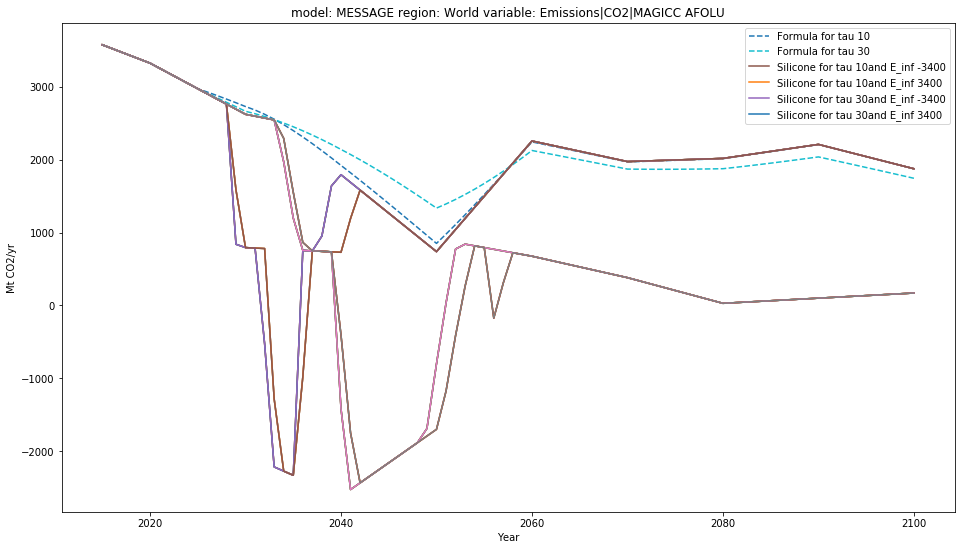

In [23]:
fig = plt.figure(figsize=(16, 9))
ax = plt.subplot(111)
# We only show the negative E-inf as they are identical
for tau in taus:
    constructed_df.filter(variable=AFOLU, scenario="tau_" + str(tau) + "_E-inf_-*").line_plot(
        ax=ax, label="Formula for tau " + str(tau), linestyle="--"
    ) 
    for Einf in E_infs:
        infilled_rcmip.filter(variable=AFOLU).line_plot(
            ax=ax, label="Silicone for tau " + str(tau) + "and E_inf " + str(Einf)
    )

Our main conclusion from this is that this database is too small to use this cruncher, hence the inter-year variability is too high. 

In [19]:
same_name_sr15 = df.filter(variable="*CO2*")
same_name_sr15["variable"] = df.data["variable"].map(lambda x: x.replace(
    "Emissions|CO2|AFOLU", AFOLU
).replace("Emissions|CO2|Energy and Industrial Processes", industry_str))

In [59]:
cruncher_sr15 = cr.DatabaseCruncherQuantileRollingWindows(same_name_sr15)
infilled_sr15 = cruncher_sr15.derive_relationship(AFOLU, [industry_str], nwindows = 10)(
    constructed_df.filter(year=same_name_sr15["year"].unique())
)

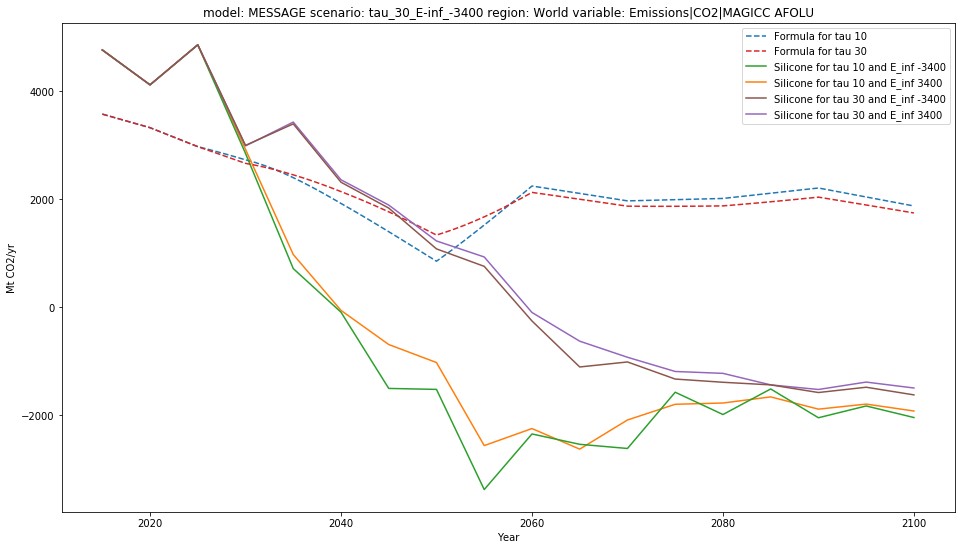

In [60]:
fig = plt.figure(figsize=(16, 9))
ax = plt.subplot(111)
# We only show the negative E-inf as they are identical
for tau in taus:
    constructed_df.filter(variable=AFOLU, scenario="tau_" + str(tau) + "_E-inf_-*").line_plot(
        ax=ax, label="Formula for tau " + str(tau), linestyle="--"
    ) 
    for Einf in E_infs:
        infilled_sr15.filter(variable=AFOLU, scenario="tau_" + str(tau) + "_E-inf_" + str(Einf) + "*").line_plot(
            ax=ax, 
            label="Silicone for tau " + str(tau) + " and E_inf " + str(Einf)
        )

In [45]:
infilled_sr15.filter(variable=AFOLU, year=2020).data

,model,scenario,region,variable,unit,year,value
1,MESSAGE,tau_10_E-inf_-3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2020,4122.601135
19,MESSAGE,tau_10_E-inf_3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2020,4122.601135
37,MESSAGE,tau_30_E-inf_-3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2020,4122.601135
55,MESSAGE,tau_30_E-inf_3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2020,4122.601135


In [35]:
infilled_sr15_09 = cruncher_sr15.derive_relationship(AFOLU, [industry_str], nwindows = 10, quantile=0.9)(
    constructed_df.filter(year=same_name_sr15["year"].unique())
)
infilled_sr15_01 = cruncher_sr15.derive_relationship(AFOLU, [industry_str], nwindows = 10, quantile=0.1)(
    constructed_df.filter(year=same_name_sr15["year"].unique())
)

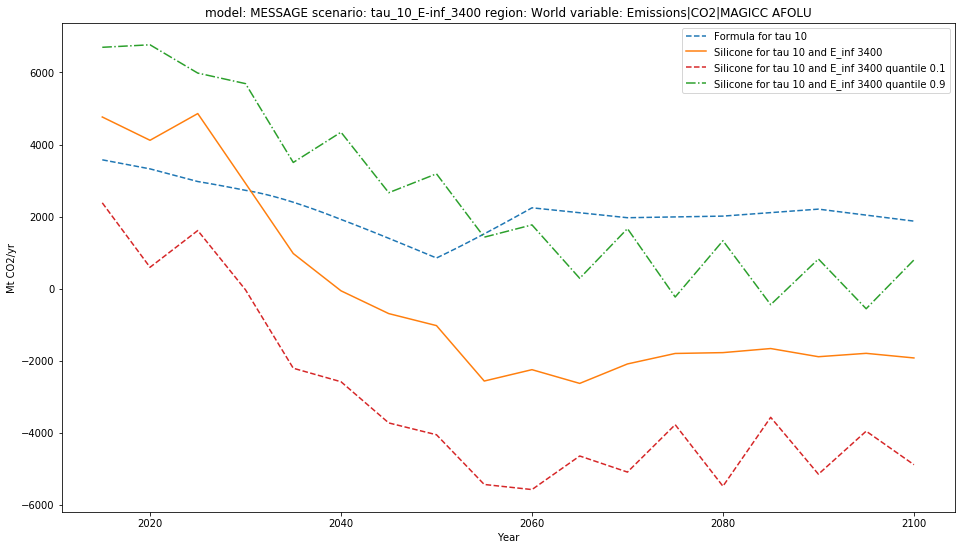

In [61]:
fig = plt.figure(figsize=(16, 9))
ax = plt.subplot(111)
# We only show the negative E-inf as they are identical
for tau in [taus[0]]:
    constructed_df.filter(variable=AFOLU, scenario="tau_" + str(tau) + "_E-inf_-*").line_plot(
        ax=ax, label="Formula for tau " + str(tau), linestyle="--"
    ) 
    for Einf in [E_infs[0]]:
        infilled_sr15.filter(variable=AFOLU, scenario="tau_" + str(tau) + "_E-inf_" + str(Einf) + "*").line_plot(
            ax=ax, 
            label="Silicone for tau " + str(tau) + " and E_inf " + str(Einf)
        )
        infilled_sr15_09.filter(variable=AFOLU, scenario="tau_" + str(tau) + "_E-inf_" + str(Einf) + "*").line_plot(
            ax=ax, label="Silicone for tau " + str(tau) + " and E_inf " + str(Einf) + " quantile 0.9", linestyle="-."
        )
        infilled_sr15_01.filter(variable=AFOLU, scenario="tau_" + str(tau) + "_E-inf_" + str(Einf) + "*").line_plot(
            ax=ax, label="Silicone for tau " + str(tau) + " and E_inf " + str(Einf) + " quantile 0.1", linestyle="--"
        )